In [3]:
import numpy as np
train_npz_file = np.load('../data/processed/train.npz')
X_train, y_train = train_npz_file['arr_0'], train_npz_file['arr_1']

In [4]:
X_train.shape, y_train.shape

((19280, 105, 105), (19280, 3))

In [5]:
X_train = X_train.reshape(X_train.shape[0], 105, 105, 1)
X_train.shape

(19280, 105, 105, 1)

In [6]:
np.unique(y_train[:, 2])

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20'], dtype='<U41')

Have an idea for a structure that constructs the type of dataset we want.  Create a dictionary with keys being the indices of the data, say.  

For each of these, we maintain a 2d tuple
- first element of this tuple is an array of indices of other (different) elements of the X, y.
- the second element of the tuple is another array.  the element of this is 0 or 1 depending on whether the corresponding element of the first array of the tuple is a different or the same character as the current key of the dictionary.

Then creating batches should be quite easy. And the size of the dictionary should control the corresponding size of the "dataset".  Accessing the structure to create batches should be fast and easy and we are just putting together access indices for X to form "pairs" and putting out the corresponding similarity labels.  

We could further embelish with some random transformations of the corresponding X at the batch level.  See how this goes.  Let's get the bare-bones up and going first.

In [171]:
import numpy as np
import pandas as pd

class BatchSampler:
    """
    Creates a batch sampler from raw-ish data pairs X, y.  The data needed for
    training a siamese networks are image pairs from X and binary indicators
    indicating whether they are equal.  Instead of forming these pairs explicitly,
    this sampler creates a dictionary with keys corresponding to the rows of X.
    The item stored at each key consists of a tuple with:
        - a list of indices of rows of X to pair with the current key
        - item a list of binary indicators inidcating whether they are of the same 
          type.
    Although this takes a while to initialize (as initialization calls this pair
    forming operation), this results in fairly efficient data storage, access and 
    batch construction.
    
    Attributes (this should probably be the actual attributes, not the entries
    to __init__, which should be in the document there)
    ----------
    X : array
        an n * h * w * n_channels array containing images, presumably from the 
        dataset we want to generate batches for (presumably for a siamese net
        training task).
    y : array
        an n * 3 array containing the specifics of the characters in X.  The
        columns are 'Alphabet', 'Character', 'Drawer'.  This makes this class
        quite specific to omniglot.
    batch_size : integer
        this represents the size of the batches we ultimately want to generate.
    half_expand_factor : integer
        this represents half of the size by which we would like to expand the
        dataset, or half of the number of pairs we would like to construct for
        each row of X.
        
    Methods
    -------
    form_pairs() 
        forms the dictionary (this should probably be a private method as it is 
        called on initialization and not meant to be used.  Then it doesn't enter 
        into the docstring here or possibly at all).
    
    This is the general idea for forming these docstrings.  Description then 
    outline Attributes and public Methods.  Functions inside then have regular
    style docstrings.  
    
    The way sampling is done here means we probably end up passing the same pairs
    in here and there, but hopefully this won't hold things up too much.  
    """
    
    
    def __init__(self, X, y, batch_size=64, half_expand_factor=4):
        self.X = X
        self.y_n_pd = y # think on whether we really need this for what we want
        self.y = pd.DataFrame(
                        data=y,
                        columns=['Alphabet', 'Character', 'Drawer']
                    )
        self.B = batch_size
        self.E = half_expand_factor
        self.n = y.shape[0]
        self.pairs = self.form_pairs()
        self.inds = np.random.permutation(y.shape[0])
        self.current_batch = 0
        self.current_efactor = 0
        self.max_batches = 1 + y.shape[0] // batch_size
        
    def form_pairs(self):
        pairs = {}
        for i in range(self.n):
            al, ch, dr = self.y.iloc[i]
            same_inds = self.y[
                    (self.y.Alphabet == al) &
                    (self.y.Character == ch) &
                    (self.y.Drawer != dr)
                ].sample(self.E, replace=False).index.values
            diff_inds = self.y[
                   ~((self.y.Alphabet == al) &
                     (self.y.Character == ch))
                ].sample(self.E, replace=False).index.values
            curr_y = np.zeros(2 * self.E)
            curr_y[:self.E] = 1
            p = np.random.permutation(2 * self.E)
            pairs[i] = (
                    np.concatenate((same_inds, diff_inds))[p],
                    curr_y[p]
                )
        return pairs
    
    def generate_batch(self):
        """
        Needs to be written.
        """
        current_inds = self.inds[
                    range(
                        self.current_batch * self.B, 
                        min((1 + self.current_batch) * self.B, self.n)
                    )
        ]
        X_b_inds, y_b = [], []
        for ind in current_inds:
            X_b_inds.append((ind, self.pairs[ind][0][self.current_efactor]))
            y_b.append(self.pairs[ind][1][self.current_efactor])
        X_b_inds = np.array(X_b_inds)
        self.current_batch = (1 + self.current_batch) % self.max_batches
        if self.current_batch == 0:
            self.current_efactor = (1 + self.current_efactor) % (2 * self.E)
        return (
                (self.X[X_b_inds[:, 0],:], 
                 self.X[X_b_inds[:, 1],:]), 
                np.array(y_b)
            )
    
    def generate_one_shot(self, n=20):
        """
        Although this could also be a class that subclasses this.
        """
        alphabet = np.random.choice(self.y.Alphabet.unique())
        drawers = np.random.choice(
                        self.y.Drawer.unique(), 
                        2, replace=False
                    )
        characters = np.random.choice(
                        self.y[
                            self.y.Alphabet == alphabet
                        ].Character.unique(),
                        n, replace=False
                    )
        
        test_inds = self.y[
                        (self.y.Alphabet == alphabet) &
                        (self.y.Drawer == drawers[0]) &
                        np.isin(self.y.Character, characters)
                    ].index.values
        
        train_inds = self.y[
                        (self.y.Alphabet == alphabet) &
                        (self.y.Drawer == drawers[1]) &
                        np.isin(self.y.Character, characters)
                    ].index.values
        return (
                    (test_inds, train_inds), 
                    (self.y.iloc[test_inds], 
                     self.y.iloc[train_inds])
        )

Looks like a pandas data frame is quite a useful way to store the labels array for the sampling tasks that we require.  

In [8]:
y_train_pd = pd.DataFrame(data=y_train, columns=['Alphabet', 'Character', 'Drawer'])

In [9]:
al_sample = np.random.choice(y_train_pd.Alphabet.unique())

In [10]:
y_train_pd[np.isin(y_train_pd.Alphabet, al_sample)].sample(5, replace=False)

,Alphabet,Character,Drawer
15591,Asomtavruli_(Georgian),character01,07
15565,Asomtavruli_(Georgian),character07,04
14927,Asomtavruli_(Georgian),character16,11
14910,Asomtavruli_(Georgian),character11,14
15348,Asomtavruli_(Georgian),character24,11


In [11]:
y_train_pd[(y_train_pd.Alphabet == al_sample) & 
           (y_train_pd.Character == 'character07')].sample(2, replace=False)

,Alphabet,Character,Drawer
15561,Asomtavruli_(Georgian),character07,13
15573,Asomtavruli_(Georgian),character07,17


In [12]:
a = y_train_pd[(y_train_pd.Alphabet == al_sample) &
           ((y_train_pd.Drawer == '13') | 
            (y_train_pd.Drawer == '12'))].sample(20, replace=False)

In [13]:
a.index

Int64Index([15099, 15375, 15528, 15541, 15562, 15227, 15296, 15314, 15313,
            15628, 15096, 15351, 15614, 15224, 15144, 15648, 15561, 15441,
            14986, 15187],
           dtype='int64')

In [14]:
y_train_pd.shape[0]

19280

In [15]:
a, b, c = y_train_pd.iloc[0]

In [16]:
a, b, c

('Gujarati', 'character42', '14')

In [17]:
al, ch, dr = y_train_pd.iloc[5]

In [18]:
al, ch, dr

('Gujarati', 'character42', '16')

In [19]:
y_train_pd[(y_train_pd.Alphabet == al) &
           (y_train_pd.Character == ch) &
           (y_train_pd.Drawer != dr)].sample(4, replace=False).index.values

array([8, 0, 2, 6])

In [20]:
y_train_pd[~((y_train_pd.Alphabet == al) &
            (y_train_pd.Character == ch))].sample(4, replace=False).index.values

array([15136,  2413,  5808,  3505])

In [172]:
a = BatchSampler(
        X_train[:2500],
        y_train[:2500],
        batch_size=7,
        half_expand_factor=2
)

In [173]:
(b, c), d = a.generate_batch()
a.current_batch, a.current_efactor, b.shape, c.shape, d

(1, 0, (7, 105, 105, 1), (7, 105, 105, 1), array([0., 1., 1., 1., 0., 0., 1.]))

In [23]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

[0. 1. 1. 1. 0. 0. 1.]


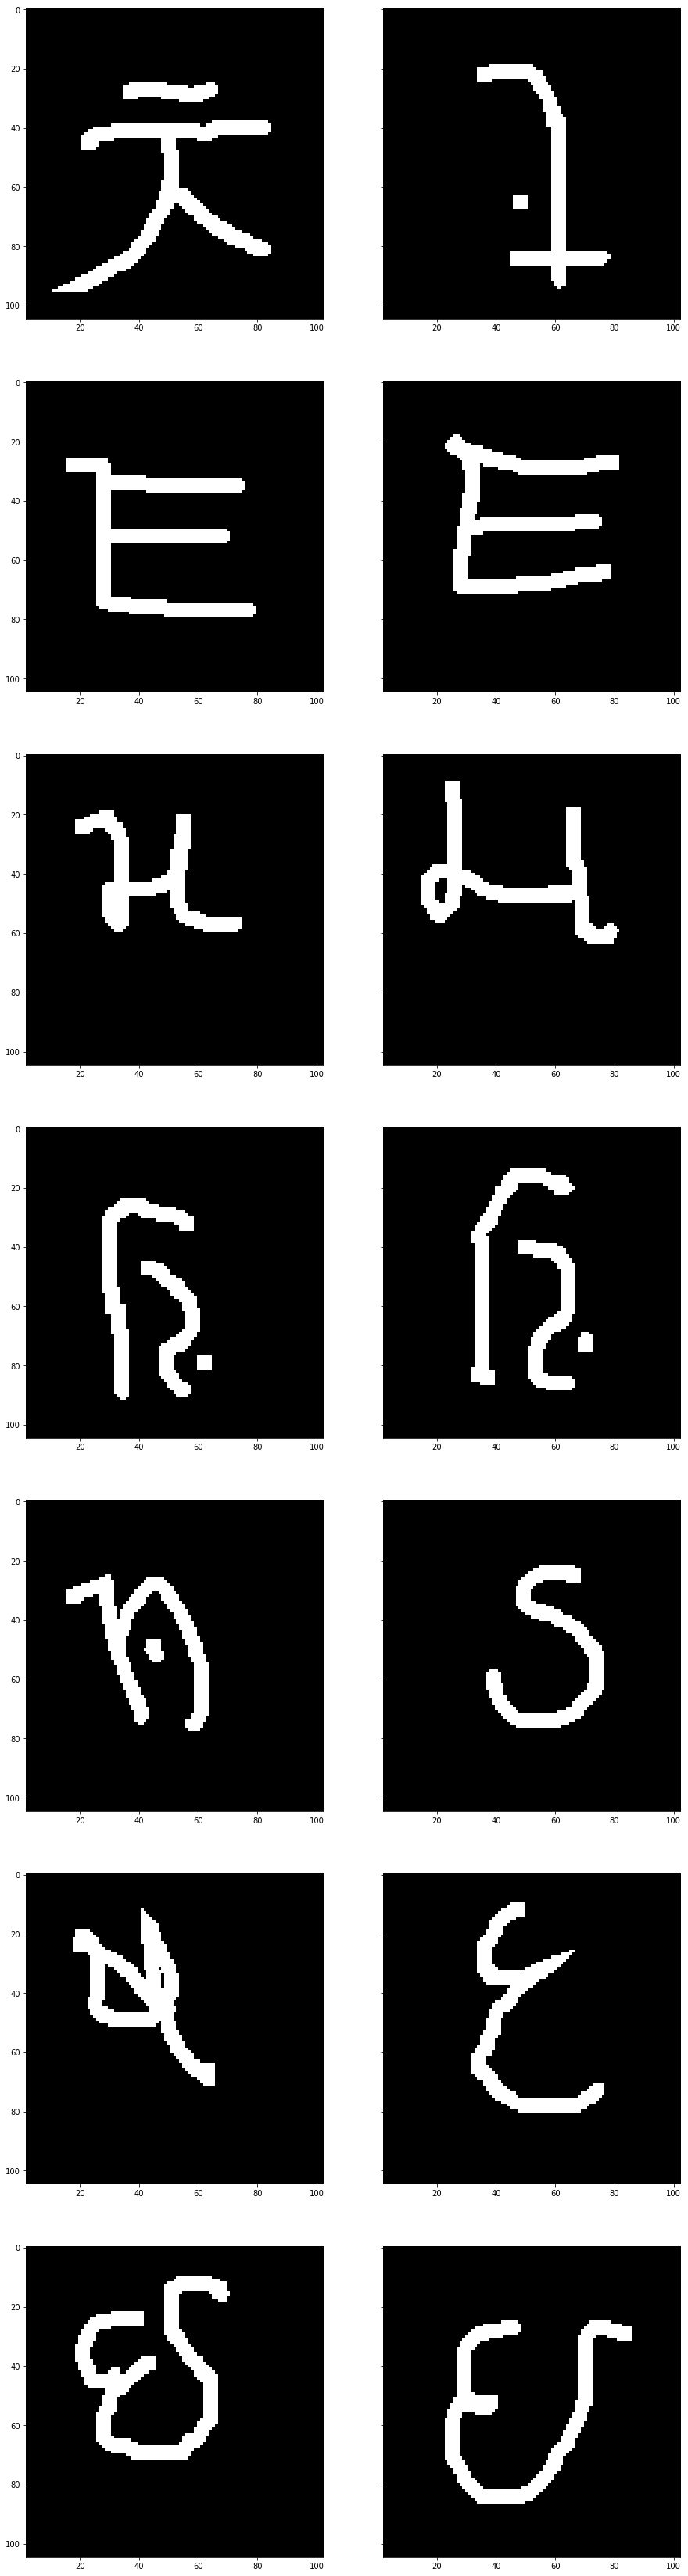

In [174]:
dim = b.shape[0]
print(d)
fig, axes = plt.subplots(dim, 2, sharey=True, figsize=(15, 60))
for i in range(dim):
    axes[i, 0].imshow(b[i, :, :, 0], cmap='Greys')
    axes[i, 1].imshow(c[i, :, :, 0], cmap='Greys')

In [268]:
(test_inds, train_inds), (u, v) = a.generate_one_shot(12)

ValueError: Cannot take a larger sample than population when 'replace=False'

In [269]:
np.concatenate((y_train[test_inds], y_train[train_inds]), axis=1)

array([['Arcadian', 'character16', '01', 'Arcadian', 'character16', '10'],
       ['Arcadian', 'character26', '01', 'Arcadian', 'character26', '10'],
       ['Arcadian', 'character19', '01', 'Arcadian', 'character19', '10'],
       ['Arcadian', 'character17', '01', 'Arcadian', 'character17', '10'],
       ['Arcadian', 'character03', '01', 'Arcadian', 'character03', '10'],
       ['Arcadian', 'character04', '01', 'Arcadian', 'character04', '10'],
       ['Arcadian', 'character02', '01', 'Arcadian', 'character02', '10'],
       ['Arcadian', 'character15', '01', 'Arcadian', 'character15', '10'],
       ['Arcadian', 'character25', '01', 'Arcadian', 'character25', '10'],
       ['Arcadian', 'character07', '01', 'Arcadian', 'character07', '10'],
       ['Arcadian', 'character01', '01', 'Arcadian', 'character01', '10'],
       ['Arcadian', 'character08', '01', 'Arcadian', 'character08', '10']],
      dtype='<U41')

In [231]:
y_20_shot = y_train_pd.iloc[:2500] 

In [253]:
for alphabet in y_train_pd.iloc[:2500].Alphabet.unique():
    print(alphabet + ': ', y_20_shot[y_20_shot.Alphabet == alphabet].Character.unique().shape[0])

Gujarati:  48
Korean:  40
Arcadian:  26
Malay_(Jawi_-_Arabic):  11


In [271]:
alphabet_lengths = []
for alphabet in y_train_pd.Alphabet.unique():
    characters = y_train_pd.Character[y_train_pd.Alphabet == alphabet].unique()
    alphabet_lengths.append(characters.shape[0])
print("Smallest number of characters in a training alphabet: {}".format(np.min(alphabet_lengths)))

Smallest number of characters in a training alphabet: 14


In [276]:
test_npz_file = np.load('../data/processed/test.npz')
X_test, y_test = test_npz_file['arr_0'], test_npz_file['arr_1']
y_test_pd = pd.DataFrame(data=y_test, columns=['Alphabet', 'Character', 'Drawer'])

In [277]:
alphabet_lengths = []
for alphabet in y_test_pd.Alphabet.unique():
    characters = y_test_pd.Character[y_test_pd.Alphabet == alphabet].unique()
    alphabet_lengths.append(characters.shape[0])
print("Smallest number of characters in a test alphabet: {}".format(np.min(alphabet_lengths)))

Smallest number of characters in a test alphabet: 20


In [279]:
y_train_pd.shape, y_test_pd.shape, y_train_pd.shape[0] + y_test_pd.shape[0]

((19280, 3), (13180, 3), 32460)

In [280]:
y_train_pd.Alphabet.unique().shape[0] + y_test_pd.Alphabet.unique().shape[0]

50

In [281]:
characters_in_test, characters_in_train = 0, 0
for alphabet in y_train_pd.Alphabet.unique():
    characters_in_alphabet = y_train_pd.Character[
                y_train_pd.Alphabet == alphabet
            ].unique().shape[0]
    characters_in_train += characters_in_alphabet
characters_in_train

964

In [282]:
for alphabet in y_test_pd.Alphabet.unique():
    characters_in_alphabet = y_test_pd.Character[
                y_test_pd.Alphabet == alphabet
            ].unique().shape[0]
    characters_in_test += characters_in_alphabet
characters_in_test

659

In [283]:
964 + 659

1623